<p align="center">
  <img src="./img/ship.png" />
</p>

In [64]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('./data/train.csv')

# **3. Modeling**
This notebook follows steps to train a model to predict the survival of a passenger. These steps include:

1. **Filling missing data**: Preprocessing data is essential to ensure that the data the model is trained on is complete and clean. This step involves filling missing values in the dataset
2. **Normalizing features**: Normalizing columns to a fixed range to improve model performance
3. **Feature selection**: Selection of feature is important. Some columns in the data set are not important or relevant when predicting survival.
4. **Model training**: Training multiple models and comparing their performance is important for the model accuracy.


## **3.1 Filling missing data**
As concluded in Notebook 0, some values for **Cabin, Embarked and Age** are missing. Because we will not be analysing or training the model for identifying columns, we do not need to fill the missing values for cabin. As the Embarked column is categorical, we will normalize the values using the One hot encoding technique so filling missing values will happen later (3.2)

In [65]:
# List all column information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### **3.1.1 Age data**

For the missing age data (177 values) we can do two things:
- Fill data with the *mean* value of Age
- Fill missing data with the *median* of Age

As concluded in notebook 1, Age follows a normal distribution pattern. In that case the best fit for the missing data will be the *mean* of Age

**Embarked data**

--------------Age Data Information--------------
count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64


Text(0.5, 1.0, 'After Filling Missing Values')

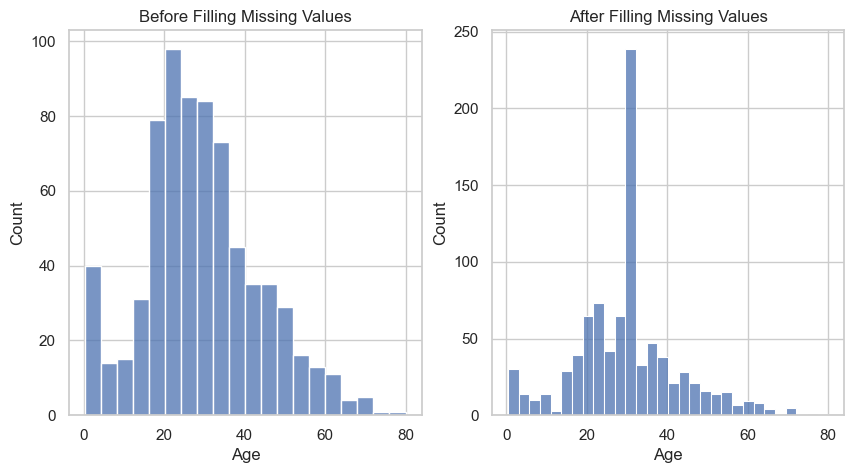

In [66]:
# Print age data information
print('--------------Age Data Information--------------')
print(df['Age'].describe())

# Plot histogram of Age column (with missing values)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(df['Age'], ax=ax[0])
ax[0].set_title('Before Filling Missing Values')

# Fill missing values in Age column with the mean value
df.fillna({'Age': df['Age'].mean()}, inplace=True)

# Plot histogram of Age column (after filling missing values)
sns.histplot(df['Age'], ax=ax[1])
ax[1].set_title('After Filling Missing Values')

### **3.1.2 Missing embarked data**
The departure data for 2 records seem to be missing. We will make sure every record has a Embark location. For missing values a new location (U = Unknown) will be introduced.

<Axes: xlabel='Embarked', ylabel='count'>

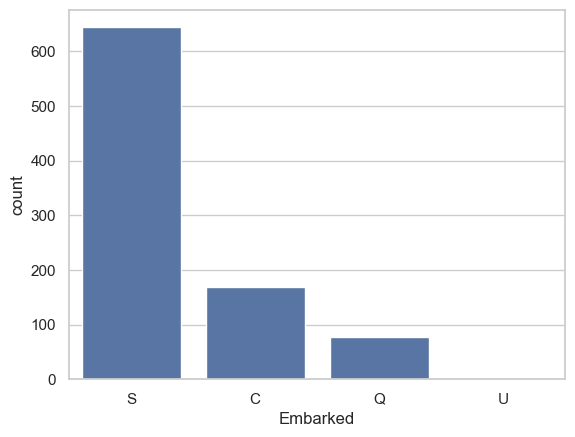

In [67]:
# Fill missing values in Embarked column with a new category 'U' for unknown
df.fillna({'Embarked': 'U'}, inplace=True)

# Plot histogram of Embarked column
sns.countplot(data=df, x='Embarked')

## **3.2 Normalizing features**

In [68]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
